In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from mealpy import FloatVar, IntegerVar, BoolVar, MixedSetVar,Problem
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination import get_termination
from scipy.interpolate import griddata
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [5]:
exp_data = pd.read_csv('C:/Users/CHUKS/Downloads/New_Biodiesel_Data.csv')
biodiesel_data = exp_data.set_index('Run')
biodiesel_data.head()

,Temperature (oC),Methanol-oil ratio (-),Catalyst conc. (%),Reaction time (min),Yield-Exp,Viscosity-Exp
Run,,,,,,
1,70,9,3,90,94.01,2.05
2,70,14,5,90,62.96,2.53
3,70,14,1,90,86.63,1.79
4,70,9,3,90,94.01,2.08
5,70,9,3,90,92.00,2.08


In [6]:
biodiesel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 1 to 29
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (oC)        29 non-null     int64  
 1   Methanol-oil ratio (-)  29 non-null     int64  
 2   Catalyst conc. (%)      29 non-null     int64  
 3   Reaction time (min)     29 non-null     int64  
 4   Yield-Exp               29 non-null     float64
 5   Viscosity-Exp           29 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 1.6 KB


In [7]:
biodiesel_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (oC),29.0,70.000000,13.093073,50.00,70.00,70.00,70.00,90.00
Methanol-oil ratio (-),29.0,9.000000,3.273268,4.00,9.00,9.00,9.00,14.00
Catalyst conc. (%),29.0,3.000000,1.309307,1.00,3.00,3.00,3.00,5.00
Reaction time (min),29.0,90.000000,19.639610,60.00,90.00,90.00,90.00,120.00
Yield-Exp,29.0,81.608276,16.720128,31.40,75.22,88.44,94.01,98.18
Viscosity-Exp,29.0,2.755172,0.701985,1.64,2.10,2.58,3.08,4.18


<IPython.core.display.Javascript object>

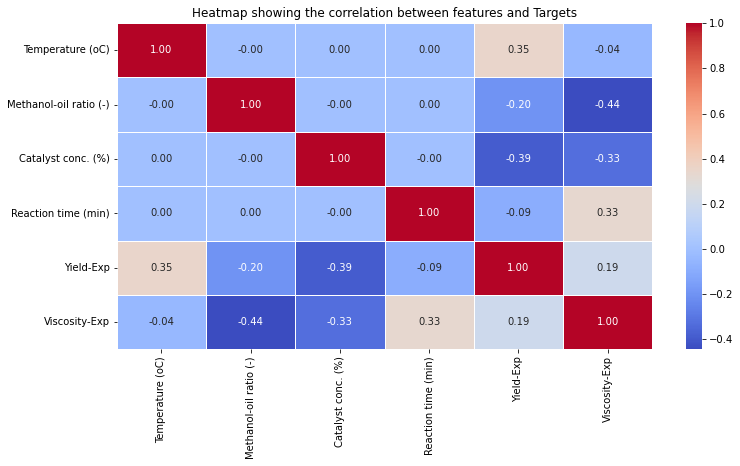

In [8]:
corr = biodiesel_data.corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap showing the correlation between features and Targets')
plt.show()

In [9]:
features = ['Temperature (oC)','Methanol-oil ratio (-)','Catalyst conc. (%)','Reaction time (min)']
Target1 = ['Yield-Exp']
Target2 = ['Viscosity-Exp']

In [10]:
y1 = biodiesel_data[Target1]
y2 = biodiesel_data[Target2]

In [11]:
X = biodiesel_data[features]
X = X.reset_index(drop=True)
X.head()

,Temperature (oC),Methanol-oil ratio (-),Catalyst conc. (%),Reaction time (min)
0,70,9,3,90
1,70,14,5,90
2,70,14,1,90
3,70,9,3,90
4,70,9,3,90


In [12]:
# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

In [13]:
# Normalize the features

X_scaler = StandardScaler()
#Y_scaler = StandardScaler()

X1_train_scale = X_scaler.fit_transform(X1_train)
X1_test_scale = X_scaler.fit_transform(X1_test)
X2_train_scale = X_scaler.fit_transform(X2_train)
X2_test_scale = X_scaler.fit_transform(X2_test)

#y1_train_scale = Y_scaler.fit_transform(y1_train.reshape(-1,1))
#y1_test_scale = Y_scaler.fit_transform(y1_test.reshape(-1,1))
#y2_train_scale = Y_scaler.fit_transform(y2_train.reshape(-1,1))
#y2_test_scale = Y_scaler.fit_transform(y2_test.reshape(-1,1))


In [14]:
print(X1_train_scale.shape)
print(X1_test_scale.shape)
print(y1_train.shape)
print(y1_test.shape)

print(X2_train_scale.shape)
print(X2_test_scale.shape)
print(y2_train.shape)
print(y2_test.shape)

(23, 4)
(6, 4)
(23, 1)
(6, 1)
(23, 4)
(6, 4)
(23, 1)
(6, 1)


In [15]:
#Build the ANN model
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def build_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(units=1))# 1 output neurons for biodiesel_yield
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

set_seed(62)

ann_model = build_ann_model(X1_train_scale.shape[1])


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [17]:
history = ann_model.fit(X1_train_scale, y1_train, epochs=100, batch_size=10, validation_data=(X1_train_scale, y1_train),
                       callbacks=[callback], verbose=1)

Epoch 1/100
3/3 [==============================] - 7s 526ms/step - loss: 7038.3389 - mean_squared_error: 7038.3389 - val_loss: 7016.1284 - val_mean_squared_error: 7016.1284
Epoch 2/100
3/3 [==============================] - 0s 80ms/step - loss: 7010.4570 - mean_squared_error: 7010.4570 - val_loss: 6987.6890 - val_mean_squared_error: 6987.6890
Epoch 3/100
3/3 [==============================] - 0s 76ms/step - loss: 6980.9761 - mean_squared_error: 6980.9761 - val_loss: 6947.2310 - val_mean_squared_error: 6947.2310
Epoch 4/100
3/3 [==============================] - 0s 76ms/step - loss: 6935.8633 - mean_squared_error: 6935.8633 - val_loss: 6884.4673 - val_mean_squared_error: 6884.4673
Epoch 5/100
3/3 [==============================] - 0s 80ms/step - loss: 6859.8218 - mean_squared_error: 6859.8218 - val_loss: 6781.8735 - val_mean_squared_error: 6781.8735
Epoch 6/100
3/3 [==============================] - 0s 76ms/step - loss: 6748.9863 - mean_squared_error: 6748.9863 - val_loss: 6614.7749 - v

In [18]:
#Evaluate the model
loss, mse = ann_model.evaluate(X1_test_scale, y1_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test MSE: {mse}")


1/1 [==============================] - 0s 101ms/step - loss: 548.2541 - mean_squared_error: 548.2541
Test Loss: 548.2540893554688
Test MSE: 548.2540893554688


In [19]:
y1_pred = ann_model.predict(X1_test_scale)

1/1 [==============================] - 1s 523ms/step


In [22]:
y1_predt = ann_model.predict(X1_train_scale)

1/1 [==============================] - 0s 78ms/step


In [23]:
y1_pred

array([[ 77.4459  ],
       [ 73.317055],
       [ 65.04182 ],
       [ 98.992744],
       [104.60461 ],
       [103.61139 ]], dtype=float32)

In [24]:
score = r2_score(y1_train,y1_predt)
score

0.9979954634024789

In [25]:
test_score = r2_score(y1_test,y1_pred)
test_score

-0.05739185635215183

In [26]:
#Build the ANN model
def build_ann_model2(input_dim):
    model2 = Sequential()
    model2.add(Dense(100, input_dim=input_dim, activation='relu'))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(units=1))# 1 output neurons for viscosity
    optimizer = Adam()
    model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model2

set_seed(62)

ann_model2 = build_ann_model(X2_train_scale.shape[1])


In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [28]:
history2 = ann_model2.fit(X2_train_scale, y2_train, epochs=100, batch_size=15, validation_data=(X2_train_scale, y2_train),
                       callbacks=[callback], verbose=1)

Epoch 1/100
2/2 [==============================] - 6s 904ms/step - loss: 7.9834 - mean_squared_error: 7.9834 - val_loss: 7.3726 - val_mean_squared_error: 7.3726
Epoch 2/100
2/2 [==============================] - 0s 155ms/step - loss: 7.2692 - mean_squared_error: 7.2692 - val_loss: 6.7405 - val_mean_squared_error: 6.7405
Epoch 3/100
2/2 [==============================] - 0s 156ms/step - loss: 6.6517 - mean_squared_error: 6.6517 - val_loss: 6.0407 - val_mean_squared_error: 6.0407
Epoch 4/100
2/2 [==============================] - 0s 151ms/step - loss: 5.9260 - mean_squared_error: 5.9260 - val_loss: 5.1841 - val_mean_squared_error: 5.1841
Epoch 5/100
2/2 [==============================] - 0s 163ms/step - loss: 4.9918 - mean_squared_error: 4.9918 - val_loss: 4.1282 - val_mean_squared_error: 4.1282
Epoch 6/100
2/2 [==============================] - 0s 153ms/step - loss: 3.9069 - mean_squared_error: 3.9069 - val_loss: 2.8886 - val_mean_squared_error: 2.8886
Epoch 7/100
2/2 [=================

In [29]:
#Evaluate the model
loss, mse = ann_model2.evaluate(X2_test_scale, y2_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test MSE: {mse}")


1/1 [==============================] - 0s 108ms/step - loss: 0.1557 - mean_squared_error: 0.1557
Test Loss: 0.15569573640823364
Test MSE: 0.15569573640823364


In [30]:
y2_pred = ann_model2.predict(X2_test_scale)

1/1 [==============================] - 0s 366ms/step


In [31]:
y2_predt = ann_model2.predict(X2_train_scale)

1/1 [==============================] - 0s 108ms/step


In [32]:
score2 = r2_score(y2_train,y2_predt)
score2

0.9966594167238366

## Train on Full Data

In [33]:
x_yield = X_scaler.fit_transform(X)

In [34]:
#Build the ANN model
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def full_build_ann_model(input_dim):
    full_model = Sequential()
    full_model.add(Dense(100, input_dim=input_dim, activation='relu'))
    full_model.add(Dense(100, activation='relu'))
    full_model.add(Dense(100, activation='relu'))
    full_model.add(Dense(100, activation='relu'))
    full_model.add(Dense(100, activation='relu'))
    full_model.add(Dense(100, activation='relu'))
    full_model.add(Dense(units=1))# 1 output neurons for biodiesel_yield
    optimizer = Adam()
    full_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return full_model

set_seed(42)

x_yield = x_yield.values if isinstance(x_yield, pd.DataFrame) else x_yield
y1 = y1.values if isinstance(y1, pd.DataFrame) else y1

full_ann_model = full_build_ann_model(x_yield.shape[1])
call_back = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
full_history = full_ann_model.fit(x_yield, y1, epochs=100, batch_size=15, validation_data=(x_yield, y1),
                       callbacks=[call_back], verbose=1)

Epoch 1/100
2/2 [==============================] - 7s 815ms/step - loss: 6915.2764 - mean_squared_error: 6915.2764 - val_loss: 6896.5864 - val_mean_squared_error: 6896.5864
Epoch 2/100
2/2 [==============================] - 0s 138ms/step - loss: 6890.1079 - mean_squared_error: 6890.1079 - val_loss: 6863.2100 - val_mean_squared_error: 6863.2100
Epoch 3/100
2/2 [==============================] - 0s 140ms/step - loss: 6852.5034 - mean_squared_error: 6852.5034 - val_loss: 6814.3550 - val_mean_squared_error: 6814.3550
Epoch 4/100
2/2 [==============================] - 0s 143ms/step - loss: 6799.5000 - mean_squared_error: 6799.5000 - val_loss: 6741.9458 - val_mean_squared_error: 6741.9458
Epoch 5/100
2/2 [==============================] - 0s 141ms/step - loss: 6720.5464 - mean_squared_error: 6720.5464 - val_loss: 6635.8555 - val_mean_squared_error: 6635.8555
Epoch 6/100
2/2 [==============================] - 0s 142ms/step - loss: 6602.6445 - mean_squared_error: 6602.6445 - val_loss: 6482.174

In [35]:
yield_predt = full_ann_model.predict(x_yield)

1/1 [==============================] - 0s 406ms/step


In [36]:
yield_score = r2_score(y1,yield_predt)
yield_score

0.9987790579747395

In [37]:
yield_mse_score = mean_squared_error(y1,yield_predt)
yield_mse_score

0.3295598128071273

In [38]:
yield_mae_score = mean_absolute_error(y1,yield_predt)
yield_mae_score

0.3898805420974215

In [39]:
yield_rmse_score = np.sqrt(mean_squared_error(y1,yield_predt))
yield_rmse_score

0.5740730030293424

In [40]:
yield_df = pd.DataFrame({'Actual': y1.flatten(), 'Predicted': yield_predt.flatten()})
yield_df

,Actual,Predicted
0,94.01,93.547974
1,62.96,62.839031
2,86.63,86.599228
3,94.01,93.547974
4,92.00,93.547974
5,68.13,68.006073
6,94.50,94.205086
7,80.14,80.031387
8,98.18,97.758194
9,96.25,95.934807


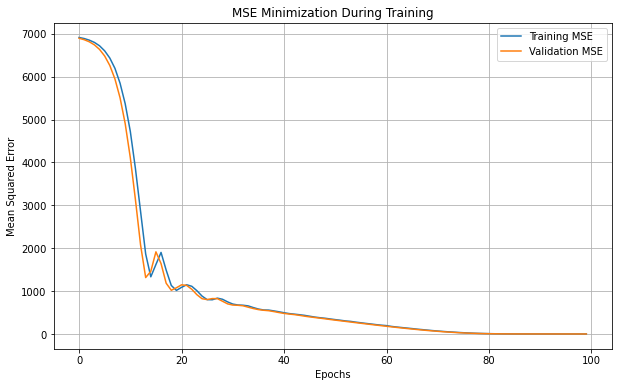

In [41]:
mse = full_history.history['mean_squared_error']
val_mse = full_history.history['val_mean_squared_error']

# Plot the training and validation mean squared error
plt.figure(figsize=(10, 6))
plt.plot(mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.title('MSE Minimization During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

#### Viscosity

In [42]:
#Build the ANN model
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def full_build_ann_model2(input_dim):
    full_model2 = Sequential()
    full_model2.add(Dense(100, input_dim=input_dim, activation='relu'))
    full_model2.add(Dense(100, activation='relu'))
    full_model2.add(Dense(100, activation='relu'))
    full_model2.add(Dense(100, activation='relu'))
    full_model2.add(Dense(100, activation='relu'))
    full_model2.add(Dense(100, activation='relu'))
    full_model2.add(Dense(units=1))# 1 output neurons for biodiesel_yield
    optimizer = Adam()
    full_model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return full_model2

set_seed(42)

x_yield = x_yield.values if isinstance(x_yield, pd.DataFrame) else x_yield
y2 = y2.values if isinstance(y2, pd.DataFrame) else y2

full_ann_model2 = full_build_ann_model2(x_yield.shape[1])
call_back2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
full_history2 = full_ann_model2.fit(x_yield, y2, epochs=100, batch_size=15, validation_data=(x_yield, y2),
                       callbacks=[call_back2], verbose=1)

Epoch 1/100
2/2 [==============================] - 7s 881ms/step - loss: 7.5580 - mean_squared_error: 7.5580 - val_loss: 6.9127 - val_mean_squared_error: 6.9127
Epoch 2/100
2/2 [==============================] - 0s 151ms/step - loss: 6.6968 - mean_squared_error: 6.6968 - val_loss: 5.8639 - val_mean_squared_error: 5.8639
Epoch 3/100
2/2 [==============================] - 0s 159ms/step - loss: 5.5597 - mean_squared_error: 5.5597 - val_loss: 4.4947 - val_mean_squared_error: 4.4947
Epoch 4/100
2/2 [==============================] - 0s 165ms/step - loss: 4.1216 - mean_squared_error: 4.1216 - val_loss: 2.8491 - val_mean_squared_error: 2.8491
Epoch 5/100
2/2 [==============================] - 0s 159ms/step - loss: 2.5722 - mean_squared_error: 2.5722 - val_loss: 1.3319 - val_mean_squared_error: 1.3319
Epoch 6/100
2/2 [==============================] - 0s 159ms/step - loss: 1.1998 - mean_squared_error: 1.1998 - val_loss: 0.9199 - val_mean_squared_error: 0.9199
Epoch 7/100
2/2 [=================

In [43]:
viscosity_predt = full_ann_model2.predict(x_yield)

1/1 [==============================] - 0s 403ms/step


In [44]:
viscosity_score = r2_score(y2,viscosity_predt)
viscosity_score

0.997208752640626

In [45]:
viscosity_mse_score = mean_squared_error(y2,viscosity_predt)
viscosity_mse_score

0.0013280489418911316

In [46]:
viscosity_rmse_score = np.sqrt(mean_squared_error(y2,viscosity_predt))
viscosity_rmse_score

0.03644240581919821

In [47]:
viscosity_mae_score = mean_absolute_error(y2,viscosity_predt)
viscosity_mae_score

0.01720643635453848

In [48]:
viscosity_df = pd.DataFrame({'Actual': y2.flatten(), 'Predicted': viscosity_predt.flatten()})
viscosity_df

,Actual,Predicted
0,2.05,2.123345
1,2.53,2.534724
2,1.79,1.793447
3,2.08,2.123345
4,2.08,2.123345
5,2.50,2.503899
6,3.02,3.025110
7,3.02,3.025904
8,2.99,2.996117
9,4.18,4.189276


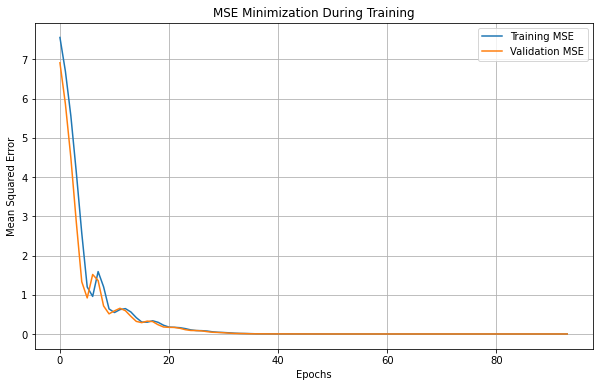

In [49]:
mse2 = full_history2.history['mean_squared_error']
val_mse2 = full_history2.history['val_mean_squared_error']

# Plot the training and validation mean squared error
plt.figure(figsize=(10, 6))
plt.plot(mse2, label='Training MSE')
plt.plot(val_mse2, label='Validation MSE')
plt.title('MSE Minimization During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

### Other Models

In [50]:
def ModelData(model, X, y, X_test, y_test):
    def ModelEvaluation(ytrue, ypred):
        print(f"Mean absolute error: {mean_absolute_error(ytrue, ypred)}")
        print(f"Root mean sqared error {np.sqrt(mean_squared_error(ytrue, ypred))}")
        print(f"R2 Score: {r2_score(ytrue, ypred)}\n")
    model.fit(X, y)
    train_pred = model.predict(X)
    test_pred = model.predict(X_test)

    print("Train result:")
    ModelEvaluation(y, train_pred)
    print("Validation result:")
    ModelEvaluation(y_test, test_pred)

### Predicting Yield

In [51]:
list_of_models = [SVR,
                  MLPRegressor,
                  MLPRegressor,
                  LinearRegression,
                  KNeighborsRegressor, 
                  RandomForestRegressor,
                  xgb.XGBRegressor]

In [52]:
for algo in list_of_models:
    print(f"Training {algo.__name__}")
    ModelData(algo(), X1_train_scale, y1_train, X1_test_scale, y1_test)

Training SVR


C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train result:
Mean absolute error: 9.382564933017653
Root mean sqared error 14.49792975279923
R2 Score: -0.05387829042202563

Validation result:
Mean absolute error: 17.008184024396854
Root mean sqared error 24.83229233088236
R2 Score: -0.1892896947066176

Training MLPRegressor


C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train result:
Mean absolute error: 72.17004505409946
Root mean sqared error 73.58728322824909
R2 Score: -26.15088654677119

Validation result:
Mean absolute error: 67.46763770952894
Root mean sqared error 71.02780233696508
R2 Score: -8.729953978782854

Training MLPRegressor


C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train result:
Mean absolute error: 73.34841834537387
Root mean sqared error 74.78657151620918
R2 Score: -27.04308085486621

Validation result:
Mean absolute error: 68.5657357072114
Root mean sqared error 72.29467186189765
R2 Score: -9.0801411380712

Training LinearRegression
Train result:
Mean absolute error: 8.500614632442813
Root mean sqared error 11.512010595677106
R2 Score: 0.33552164696809095

Validation result:
Mean absolute error: 14.892882102267535
Root mean sqared error 19.518878444765836
R2 Score: 0.2652091320261569

Training KNeighborsRegressor
Train result:
Mean absolute error: 7.813739130434778
Root mean sqared error 12.319548565981027
R2 Score: 0.2390290745259278

Validation result:
Mean absolute error: 17.31833333333333
Root mean sqared error 21.014205147946946
R2 Score: 0.14831310133784215

Training RandomForestRegressor


C:\Users\CHUKS\AppData\Local\Temp/ipykernel_5360/888336880.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


Train result:
Mean absolute error: 4.029403768115965
Root mean sqared error 5.246448770928571
R2 Score: 0.861990383487443

Validation result:
Mean absolute error: 12.199810079365108
Root mean sqared error 19.09472650935882
R2 Score: 0.29679667410164556

Training XGBRegressor
Train result:
Mean absolute error: 0.21409761511761122
Root mean sqared error 0.46622533529152876
R2 Score: 0.9989101412484417

Validation result:
Mean absolute error: 11.901781565348307
Root mean sqared error 20.077160732953082
R2 Score: 0.2225747839648603



### Predicting Viscosity

In [53]:
for algo in list_of_models:
    print(f"Training {algo.__name__}")
    ModelData(algo(), X2_train_scale, y2_train, X2_test_scale, y2_test)

Training SVR
Train result:
Mean absolute error: 0.11074494082908945
Root mean sqared error 0.12226468427881576
R2 Score: 0.9696738861461444

Validation result:
Mean absolute error: 0.4408932887784014
Root mean sqared error 0.4899696486006557
R2 Score: 0.3295011337894128

Training MLPRegressor


C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Train result:
Mean absolute error: 0.23016160315117448
Root mean sqared error 0.31114918716595447
R2 Score: 0.8035952254158457

Validation result:
Mean absolute error: 0.5619961490951128
Root mean sqared error 0.6012766012122019
R2 Score: -0.00973706462917745

Training MLPRegressor


C:\Users\CHUKS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\CHUKS\AppData\Local\Temp/ipykernel_5360/888336880.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


Train result:
Mean absolute error: 0.2180367826619005
Root mean sqared error 0.31265654859779596
R2 Score: 0.8016876511175239

Validation result:
Mean absolute error: 0.5911336774347058
Root mean sqared error 0.6290369098357027
R2 Score: -0.10512638941817176

Training LinearRegression
Train result:
Mean absolute error: 0.4930991951997713
Root mean sqared error 0.5529537355931027
R2 Score: 0.3797135525745202

Validation result:
Mean absolute error: 0.4139699715284115
Root mean sqared error 0.46858877331731835
R2 Score: 0.38674167860810926

Training KNeighborsRegressor
Train result:
Mean absolute error: 0.44391304347826077
Root mean sqared error 0.5761767542811086
R2 Score: 0.3265177327811015

Validation result:
Mean absolute error: 0.6813333333333332
Root mean sqared error 0.767784692041547
R2 Score: -0.646412251642785

Training RandomForestRegressor
Train result:
Mean absolute error: 0.2094841166321595
Root mean sqared error 0.264811497064722
R2 Score: 0.8577381759887186

Validation re

## Genetic Algorithm

In [54]:
data = {
    "X1_train": X1_train,
    "X1_test": X1_test,
    "y1_train": y1_train,
    "y1_test": y1_test,
    "X2_train": X2_train,
    "X2_test": X2_test,
    "y2_train": y2_train,
    "y2_test": y2_test
}


### GA Optimization

In [55]:
model_yield = xgb.XGBRegressor(objective='reg:squarederror')
model_yield.fit(data["X1_train"], data["y1_train"])

model_viscosity = xgb.XGBRegressor(objective='reg:squarederror')
model_viscosity.fit(data["X2_train"], data["y2_train"])

# Define the multi-objective optimization problem
class XGBMultiObjectiveProblem(Problem):
    def __init__(self, model_yield, model_viscosity, data):
        super().__init__(n_var=4, n_obj=2, n_constr=0, xl=np.array([50, 4, 1, 60]), xu=np.array([90, 14, 5, 120]))
        self.model_yield = model_yield
        self.model_viscosity = model_viscosity
        self.data = data

    def _evaluate(self, X, out, *args, **kwargs):
        n_samples = X.shape[0]
        
        yield_scores = np.zeros(n_samples)
        viscosity_scores = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Predict yield (negative for maximization)
            y1_predict = self.model_yield.predict(np.array([X[i]]))
            yield_scores[i] = -y1_predict[0]  # the first value is taken because we predict one sample
            
            # Predict viscosity (positive for minimization)
            y2_predict = self.model_viscosity.predict(np.array([X[i]]))
            viscosity_scores[i] = y2_predict[0]  # the first value is taken because we predict one sample
        
        out["F"] = np.column_stack([yield_scores, viscosity_scores])

# Initialize the problem
problem = XGBMultiObjectiveProblem(model_yield, model_viscosity, data)

# Define NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

# Define the termination criterion
termination = get_termination("n_gen", 100)

# Perform the optimization
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# Print the Pareto front solutions
pareto_solutions = res.X
for idx, solution in enumerate(pareto_solutions):
    print(f"Solution {idx + 1}:")
    print(f"    Decision Variables: Temperature: {solution[0]}, Methanol-Oil Ratio: {solution[1]}, Catalyst Conc(%): {solution[2]}, Reaction-Time(min): {solution[3]}")
    print(f"    Yield: {-res.F[idx][0]}, Viscosity: {res.F[idx][1]}")


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     17 |             - |             -
     2 |      200 |     36 |  0.0071114884 |         ideal
     3 |      300 |     70 |  0.000000E+00 |             f
     4 |      400 |    100 |  0.000000E+00 |             f
     5 |      500 |    100 |  0.000000E+00 |             f
     6 |      600 |    100 |  0.000000E+00 |             f
     7 |      700 |    100 |  0.000000E+00 |             f
     8 |      800 |    100 |  0.000000E+00 |             f
     9 |      900 |    100 |  0.000000E+00 |             f
    10 |     1000 |    100 |  0.000000E+00 |             f
    11 |     1100 |    100 |  0.000000E+00 |             f
    12 |     1200 |    100 |  0.000000E+00 |             f
    13 |     1300 |    100 |  0.000000E+00 |             f
    14 |     1400 |    100 |  0.000000E+00 |             f
    15 |     1500 |    100 |  0.000000E+00 |             f
    16 |     1600 |    100 |  0.000000E+00 |            

In [56]:
best_idx = np.argmax(-res.F[:, 0] + res.F[:, 1])

# Print the best solutions
best_solution = res.X[best_idx]
print("Best Solution:")
print(f"    Decision Variables: Temperature: {best_solution[0]},Methanol-Oil Ratio: {best_solution[1]}, Catalyst Conc(%): {best_solution[2]}, Reaction time(min): {best_solution[3]}")
print(f"    Yield: {-res.F[best_idx, 0]}, Viscosity: {res.F[best_idx, 1]}")

Best Solution:
    Decision Variables: Temperature: 68.3088388342128,Methanol-Oil Ratio: 6.275711991909941, Catalyst Conc(%): 2.6255049431212245, Reaction time(min): 72.13551236022793
    Yield: 97.93824768066406, Viscosity: 2.6899187564849854


### Plots

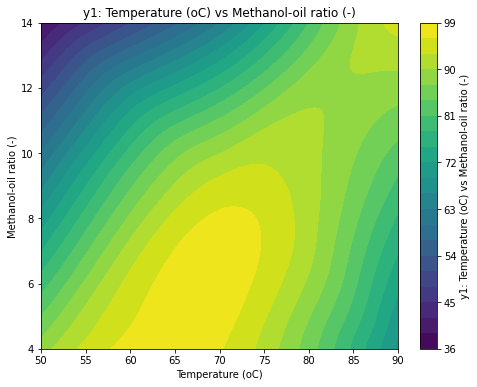

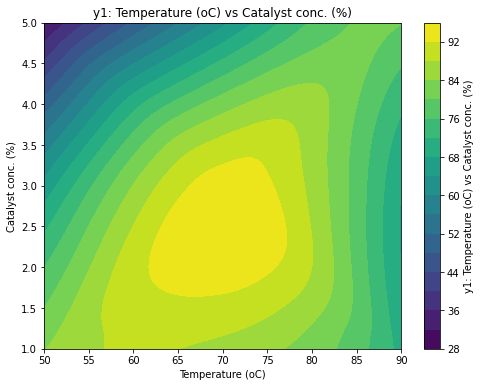

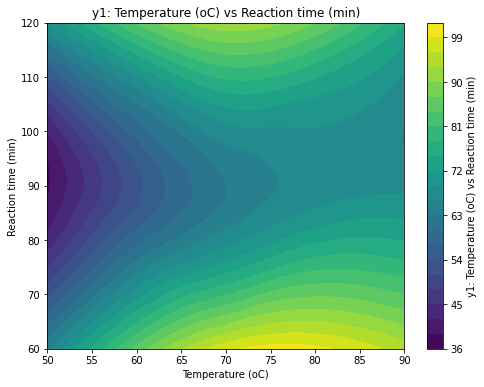

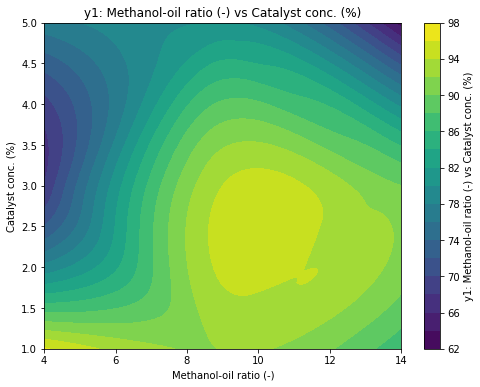

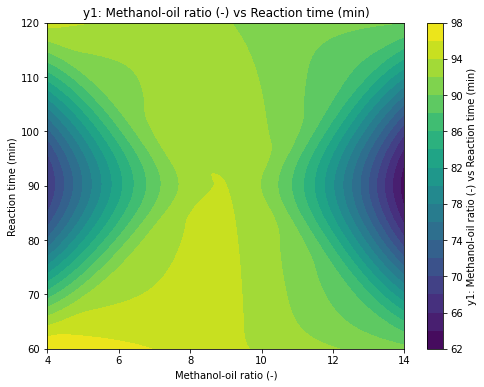

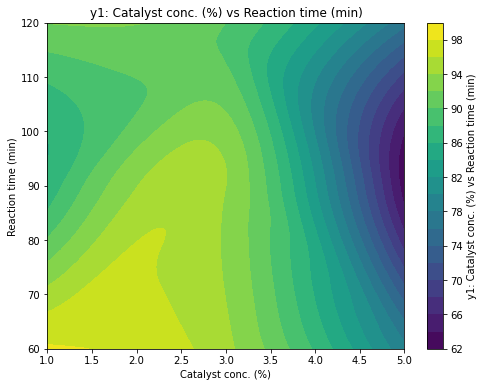

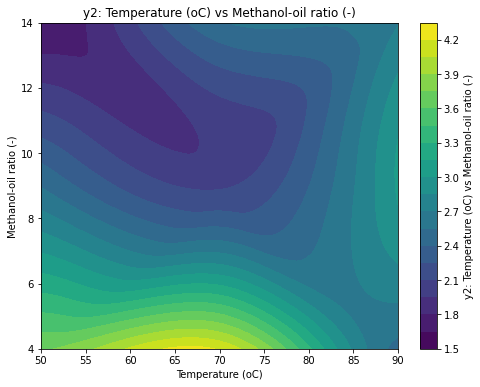

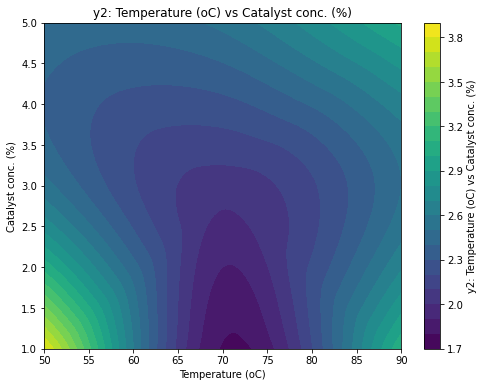

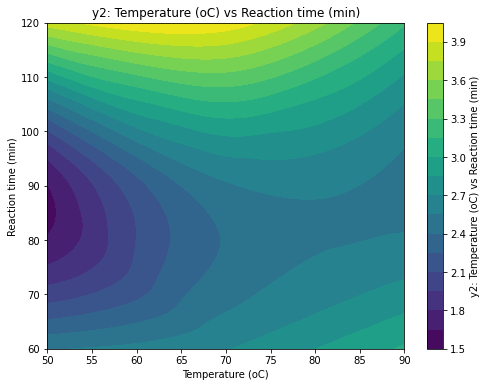

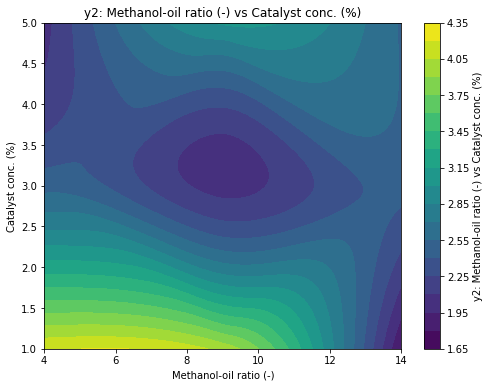

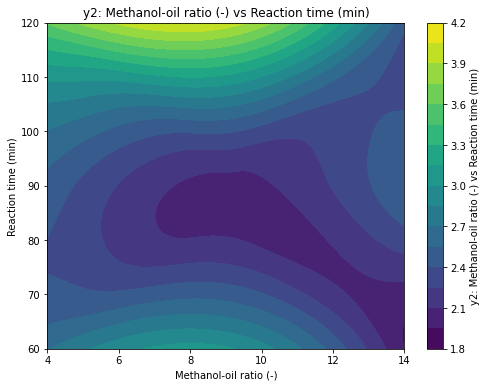

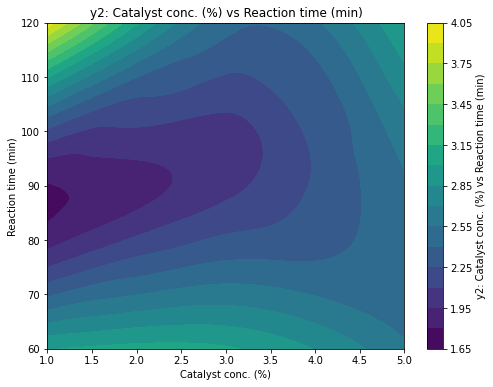

In [66]:

# Extract features and targets
x1 = biodiesel_data['Temperature (oC)'].values
x2 = biodiesel_data['Methanol-oil ratio (-)'].values
x3 = biodiesel_data['Catalyst conc. (%)'].values
x4 = biodiesel_data['Reaction time (min)'].values
y1 = biodiesel_data['Yield-Exp'].values
y2 = biodiesel_data['Viscosity-Exp'].values

# Function to create and show contour plot
def create_contour_plot(x, y, z, xlabel, ylabel, title):
    # Define the grid for contour plot
    grid_x, grid_y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    # Plot the contour
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='viridis')
    plt.colorbar(contour, label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# List of features and their names
features = [x1, x2, x3, x4]
feature_names = ['Temperature (oC)', 'Methanol-oil ratio (-)', 'Catalyst conc. (%)', 'Reaction time (min)']

# Create contour plots for y1
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        create_contour_plot(features[i], features[j], y1, feature_names[i], feature_names[j], f'y1: {feature_names[i]} vs {feature_names[j]}')

# Create contour plots for y2
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        create_contour_plot(features[i], features[j], y2, feature_names[i], feature_names[j], f'y2: {feature_names[i]} vs {feature_names[j]}')


In [95]:
# Extract features and targets
x1 = biodiesel_data['Temperature (oC)'].values
x2 = biodiesel_data['Methanol-oil ratio (-)'].values
x3 = biodiesel_data['Catalyst conc. (%)'].values
x4 = biodiesel_data['Reaction time (min)'].values
y1 = biodiesel_data['Yield-Exp'].values
y2 = biodiesel_data['Viscosity-Exp'].values

# Function to create and save 3D contour plot
def create_3d_contour_plot(x, y, z, xlabel, ylabel, zlabel, title, filename):
    # Define the grid for contour plot
    grid_x, grid_y = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    
    # Plot the 3D contour
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(grid_x, grid_y, grid_z, cmap='coolwarm')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    
    # Save the plot as a PNG file
    plt.savefig(filename)
    plt.close()
    print(f"Saved plot: {filename}")


# List of features and their names
features = [x1, x2, x3, x4]
feature_names = ['X1', 'X2', 'X3', 'X4']

# Create and save 3D contour plots for y1
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        filename = f'y1_{feature_names[i]}_vs_{feature_names[j]}.png'
        create_3d_contour_plot(features[i], features[j], y1, feature_names[i], feature_names[j], 'Yield-Exp', f'y1: {feature_names[i]} vs {feature_names[j]}', filename)

# Create and save 3D contour plots for y2
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        filename =  f'y2_{feature_names[i]}_vs_{feature_names[j]}.png'
        create_3d_contour_plot(features[i], features[j], y2, feature_names[i], feature_names[j], 'Viscosity-Exp', f'y2: {feature_names[i]} vs {feature_names[j]}', filename)


Saved plot: y1_X1_vs_X2.png
Saved plot: y1_X1_vs_X3.png
Saved plot: y1_X1_vs_X4.png
Saved plot: y1_X2_vs_X3.png
Saved plot: y1_X2_vs_X4.png
Saved plot: y1_X3_vs_X4.png
Saved plot: y2_X1_vs_X2.png
Saved plot: y2_X1_vs_X3.png
Saved plot: y2_X1_vs_X4.png
Saved plot: y2_X2_vs_X3.png
Saved plot: y2_X2_vs_X4.png
Saved plot: y2_X3_vs_X4.png
